In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import time
from datetime import datetime
import scipy.optimize as opt
from sklearn.utils.extmath import cartesian
#np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
plt.style.use("ggplot")
plt.rcParams["font.size"] = 13
mpl.rcParams["font.family"] = 'Osaka'

## Overview

* Focus on the last quarter of 2018 (October 2018 to December 2018)

* Assume that the hash supply is linear in reward:

\[
H(t) = \alpha + \beta R(t)
\]

The estimators are

\[
\hat{\alpha} = 23.60, \hat{\beta} = 9.02, \quad
\sigma(\hat{\alpha}) = 2.25, \sigma(\hat{\beta}) = 0.99
\]

## Method

### Data Cleaning

* Compute the block time using timestamps.

* Basically, the time required to generate the $i$-th block is $\Delta_i := t_i - t_{i-1}$.
    - However, sometimes $\Delta_i$ becomes negative due to inaccuracy.

* We conduct our analysis as follows:

Let $\{t_i\}_i$ be the times recorded in timestamps. For each $i$, let

$$
k^* = \min_{k \geq 1} \{k \colon t_i < t_{i+k}\}
$$
and linearly interpolate $t_0, t_1, \dots, t_k$ by the function `adjust_BGT`.

In [2]:
def adjust_BGT(raw_times):
    '''
    adjust block generation time.
    Conduct linear interpolation if the order of time stamps are reversed.
    
    Parameters
    ----------
    raw_times:
        pandas Series containing raw time stamps(unixtime)
        The index should starts at zero.
        
    Returns
    -------
    times:
        Adjusted time stamps.
    '''
    times = raw_times.copy()
    for i in range(times.shape[0] - 1):
        if times[i+1] - times[i] < 0:
            count = 1
            diff = -1
            while diff < 0:
                count += 1
                diff = times[i+count] - times[i]
            delta = times[i+count] - times[i]
            for j in range(count-1):
                times[i+j+1] = times[i] + (delta/count)*(j+1)

    return times

### Estimate the hash supply function in BTC system

$$
h(R) = \alpha + \beta R
$$

* The loglikelihood is

$$
\log \mathcal{L}(\alpha,\beta) = \sum_{t} \left\{ \log D(t) + \log(\alpha + \beta R(t)) -D(t)(\alpha + \beta R(t))B(t) \right\}
\propto
\sum_{t} \left\{\log(\alpha + \beta R(t)) -D(t)(\alpha + \beta R(t))B(t) \right\}
$$


* Focus on October 2018 to December 2018. Here, we include the transaction fee in expected reward.

* The maximization of the likelihood function is done by brute-force search.
    - NB: Iterative methods did not work well in this case.

In [3]:
path = '../data/BTCdata_2.csv'
df_BTC = pd.read_csv(path, header=0)
df_BTC = df_BTC.rename(columns={'unixtime_precise': 'unixtime'})
df_BTC = df_BTC.loc[: ,['height', 'unixtime', 'probability of success /Eh', 'expected return (USD/Eh)']]
df_BTC['time'] = pd.to_datetime(df_BTC['unixtime'].astype(int), unit='s')
df_BTC = df_BTC.sort_values(by='height', ascending=True)
df_BTC.head()

,height,unixtime,probability of success /Eh,expected return (USD/Eh),time
0,450001,1485382343,0.000593,6.935004,2017-01-25 22:12:23
1,450002,1485383957,0.000593,7.424957,2017-01-25 22:39:17
2,450003,1485384299,0.000593,7.184180,2017-01-25 22:44:59
3,450004,1485384419,0.000593,7.025926,2017-01-25 22:46:59
4,450005,1485384847,0.000593,7.086069,2017-01-25 22:54:07


In [4]:
df_BTC_2018OctDec = df_BTC[(df_BTC['time'] >= datetime(2018,9,30)) & (df_BTC['time'] <= datetime(2019,1,1))]
df_BTC_2018OctDec = df_BTC_2018OctDec.reset_index(drop=True)
BTC_times = df_BTC_2018OctDec['unixtime']
df_BTC_2018OctDec['adj_time'] = adjust_BGT(BTC_times)
df_BTC_2018OctDec['adj_block_gen_time(min)'] = df_BTC_2018OctDec['adj_time'].diff()/60
df_BTC_2018OctDec = df_BTC_2018OctDec[df_BTC_2018OctDec['time'] >= datetime(2018,10,1)]
df_BTC_2018OctDec.head()

,height,unixtime,probability of success /Eh,expected return (USD/Eh),time,adj_time,adj_block_gen_time(min)
163,543835,1538352272,0.000033,2.720620,2018-10-01 00:04:32,1538352272,18.633333
164,543836,1538352799,0.000033,2.711797,2018-10-01 00:13:19,1538352799,8.783333
165,543837,1538352841,0.000033,2.694189,2018-10-01 00:14:01,1538352841,0.700000
166,543838,1538352940,0.000033,2.697526,2018-10-01 00:15:40,1538352940,1.650000
167,543839,1538353463,0.000033,2.714195,2018-10-01 00:24:23,1538353463,8.716667


In [5]:
df = df_BTC_2018OctDec.loc[:, ['adj_block_gen_time(min)', 'probability of success /Eh', 'expected return (USD/Eh)']]
df['adj_block_gen_time(hour)'] = df['adj_block_gen_time(min)']/60
df.head()

,adj_block_gen_time(min),probability of success /Eh,expected return (USD/Eh),adj_block_gen_time(hour)
163,18.633333,0.000033,2.720620,0.310556
164,8.783333,0.000033,2.711797,0.146389
165,0.700000,0.000033,2.694189,0.011667
166,1.650000,0.000033,2.697526,0.027500
167,8.716667,0.000033,2.714195,0.145278


In [7]:
def log_likelihood(params, block_times, block_gen_rates, exp_rewards):
    '''
    params = [a, b]
    '''    
    a = params[0]
    b = params[1]
    
    temp = np.log(a + b * exp_rewards) \
        - (block_gen_rates * (a + b * exp_rewards) * block_times)
    ll = np.sum(temp)
    
    return ll


def greedy_max_ll(params_list, df):
    block_times = df.loc[:, 'adj_block_gen_time(hour)'].values
    block_gen_rates = df.loc[:, 'probability of success /Eh'].values
    exp_rewards = df.loc[:, 'expected return (USD/Eh)'].values

    opt_params = None
    opt_ll = - np.inf
    for params in params_list:
        current_ll = log_likelihood(params, block_times, block_gen_rates, exp_rewards)
        if current_ll > opt_ll:
            opt_params = params
            opt_ll = current_ll
            
    return opt_ll, opt_params

In [17]:
a = np.arange(80000, 90000, 10)
b = np.arange(30000, 60000, 10)
params_list = cartesian((a,b))
opt_ll, opt_params = greedy_max_ll(params_list, df)

In [18]:
opt_ll

138574.9971425061

In [19]:
opt_params

array([84940, 32480])

Therefore, the MLE is
$$
\hat{\alpha} = 84940, \hat{\beta} = 32480
$$

In [21]:
# Rescale the unit in seconds.
alpha = opt_params[0]/3600
beta = opt_params[1]/3600
print(alpha, beta)

23.594444444444445 9.022222222222222


In [8]:
# save the rescaled result
alpha = 23.5944
beta = 9.0222

In [22]:
df['expected return (USD/Eh)'].min()

1.5776613819999998

In [23]:
df['expected return (USD/Eh)'].max()

3.1193656539999997

In [ ]:
df

The graph looks like as follows:

In [3]:
@np.vectorize
def sigmoid(x):
    sigmoid_range = 34.538776394910684

    if x <= -sigmoid_range:
        return 1e-15
    if x >= sigmoid_range:
        return 1.0 - 1e-15

    return 1.0 / (1.0 + np.exp(-x))


center = 1.5
@np.vectorize
# hash_ubd=55, hash_slope=3, hash_center=1.5
def hash(exp_reward):
    return 55 * sigmoid(3 * (exp_reward - center))

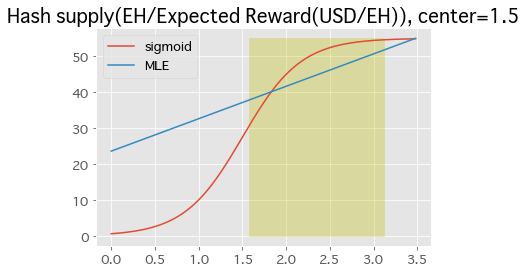

In [24]:
#plot
x = np.arange(0,3.5,0.02)
y = hash(x)
plt.plot(x,y, label='sigmoid')
z = alpha + x * beta
plt.plot(x,z, label='MLE')
plt.title('Hash supply(EH/Expected Reward(USD/EH)), center={}'.format(center))
plt.legend()
testx = [1.578, 3.12, 3.12, 1.578]
testy = [0, 0, 55, 55]
plt.fill(testx,testy,color="y",alpha=0.3)
plt.show()

## Appendix

### Compute the standard deviation

* Here, we compute the standard deviation via bootstrap.
    - http://www.math.s.chiba-u.ac.jp/~wang/bootstrap.pdf
    - https://qiita.com/katsu1110/items/23b8a37ac400dd0eaad2

* Let $T$ be the number of trials.
* In each step $t \in [T]$, draw $n$ samples  with replacement and compute the statistics.
* After obtaining $T$ statistics, we compute the average and standard deviation.

In [19]:
# import data

path = '../data/BTCdata_2.csv'
df_BTC = pd.read_csv(path, header=0)
df_BTC = df_BTC.rename(columns={'unixtime_precise': 'unixtime'})
df_BTC = df_BTC.loc[: ,['height', 'unixtime', 'probability of success /Eh', 'expected return (USD/Eh)']]
df_BTC['time'] = pd.to_datetime(df_BTC['unixtime'].astype(int), unit='s')
df_BTC = df_BTC.sort_values(by='height', ascending=True)
df_BTC_2018OctDec = df_BTC[(df_BTC['time'] >= datetime(2018,9,30)) & (df_BTC['time'] <= datetime(2019,1,1))]
df_BTC_2018OctDec = df_BTC_2018OctDec.reset_index(drop=True)
BTC_times = df_BTC_2018OctDec['unixtime']
df_BTC_2018OctDec['adj_time'] = adjust_BGT(BTC_times)
df_BTC_2018OctDec['adj_block_gen_time(min)'] = df_BTC_2018OctDec['adj_time'].diff()/60
df_BTC_2018OctDec = df_BTC_2018OctDec[df_BTC_2018OctDec['time'] >= datetime(2018,10,1)]
df = df_BTC_2018OctDec.loc[:, ['adj_block_gen_time(min)', 'probability of success /Eh', 'expected return (USD/Eh)']]
df['adj_block_gen_time(hour)'] = df['adj_block_gen_time(min)']/60
df.head()

,adj_block_gen_time(min),probability of success /Eh,expected return (USD/Eh),adj_block_gen_time(hour)
163,18.633333,0.000033,2.720620,0.310556
164,8.783333,0.000033,2.711797,0.146389
165,0.700000,0.000033,2.694189,0.011667
166,1.650000,0.000033,2.697526,0.027500
167,8.716667,0.000033,2.714195,0.145278


In [20]:
df = df.reset_index(drop=True)
df.head()

,adj_block_gen_time(min),probability of success /Eh,expected return (USD/Eh),adj_block_gen_time(hour)
0,18.633333,0.000033,2.720620,0.310556
1,8.783333,0.000033,2.711797,0.146389
2,0.700000,0.000033,2.694189,0.011667
3,1.650000,0.000033,2.697526,0.027500
4,8.716667,0.000033,2.714195,0.145278


https://stackoverflow.com/questions/31502958/drawing-a-bootstrap-sample-from-a-pandas-dataframe

In [50]:
def bootstrap(df, a_lbd=75000, a_ubd=95000, b_lbd=28000, b_ubd=38000, num_draw=1000, grid_size=100):
    alpha_list = []
    beta_list = []
    for _ in range(num_draw):
        randlist = pd.DataFrame(index=np.random.randint(df.shape[0], size=df.shape[0]))
        df_temp = df.merge(randlist, left_index=True, right_index=True, how='right')
        a = np.arange(a_lbd, a_ubd, grid_size)
        b = np.arange(b_lbd, b_ubd, grid_size)
        params_list = cartesian((a,b))
        opt_ll, opt_params = greedy_max_ll(params_list, df_temp)
        alpha_list.append(opt_params[0])
        beta_list.append(opt_params[1])
    return np.array(alpha_list), np.array(beta_list)

In [33]:
bootstrap(df, num_draw=2)

([87100, 86000], [31600, 32700])

In [39]:
bootstrap(df, num_draw=10)

([80000, 94900, 94900, 94900, 80000, 94900, 93600, 80000, 80000, 86100],
 [34800, 28400, 28900, 29500, 34300, 28800, 28200, 34700, 34600, 32300])

In [42]:
bootstrap(df, a_lbd=75000, a_ubd=95000, b_lbd=28000, b_ubd=38000, num_draw=10, grid_size=100)

([81900, 75600, 75100, 81800, 87600, 78200, 88800, 88600, 91400, 94300],
 [33400, 36700, 35500, 33400, 32400, 36100, 30100, 32400, 28700, 28000])

In [51]:
alphas, betas = bootstrap(df, a_lbd=75000, a_ubd=95000, b_lbd=28000, b_ubd=38000, num_draw=10, grid_size=100)
print(alphas)
print(betas)

[93200 83700 87000 79600 94900 94900 75000 81000 78900 76400]
[29600 33400 31800 35000 28400 28400 37500 34200 34600 36700]


In [52]:
alphas, betas = bootstrap(df, a_lbd=70000, a_ubd=100000, b_lbd=28000, b_ubd=38000, num_draw=10, grid_size=100)
print(alphas)
print(betas)

[94500 80600 87500 80700 84400 71700 91200 98200 95200 94800]
[28000 34400 31500 34500 31700 37900 29500 28000 28000 28000]


In [53]:
alphas, betas = bootstrap(df, a_lbd=70000, a_ubd=100000, b_lbd=20000, b_ubd=40000, num_draw=10, grid_size=100)
print(alphas)
print(betas)

[72700 92900 70000 86200 78100 82600 75600 92000 85600 83400]
[37400 28800 38300 31300 34600 34300 35900 29400 32700 34100]


* It seems that alpha should be in [70000, 100000], beta should be in [20000, 40000].

In [55]:
alphas, betas = bootstrap(df, a_lbd=70000, a_ubd=100000, b_lbd=20000, b_ubd=40000, num_draw=1000, grid_size=100)
alpha_std = np.std(alphas, ddof=1)
beta_std = np.std(betas, ddof=1)
print(alpha_std, beta_std)

8093.372757546299 3547.3910107264724


In [56]:
alphas.mean()

84949.7

Therefore, the standard deviation of MLE $\hat{\alpha}, \hat{\beta}$ is
\[
\sigma(\hat{\alpha}) = 8093.37, \sigma(\hat{\beta}) = 3547.39
\]

In [60]:
df_MLE = pd.DataFrame({'alphas' : alphas, 'betas': betas})
df_MLE.head()

,alphas,betas
0,86200,31900
1,76300,37000
2,91800,30100
3,83300,32900
4,70100,38600


In [61]:
# save the result
df_MLE.to_csv('../data/mle_bootstrap.csv')